In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Input, Dropout, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import joblib

In [ ]:
# Load images from folders
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return np.array(images)

In [ ]:
print("Loading images...")
# Load normal and stroke images
normal_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Normal')
stroke_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Stroke')
print(f"Loaded {len(normal_images)} normal images and {len(stroke_images)} stroke images.")

Loading images...
Loaded 1551 normal images and 950 stroke images.


In [ ]:
print("Assigning labels...")
normal_labels = np.zeros(len(normal_images))
stroke_labels = np.ones(len(stroke_images))

Assigning labels...


In [ ]:
# Combine images and labels
X = np.concatenate((normal_images, stroke_images), axis=0)
y = np.concatenate((normal_labels, stroke_labels), axis=0)

In [ ]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
print(y)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [ ]:
def preprocess_data(X):
    X = X.astype('float32')
    X = X / 255.0  # Normalize pixel values to [0, 1]
    return X

# Preprocess the images
X_resized = preprocess_data(X)
print("Shape of X_resized:", X_resized.shape)


def extract_features(model, X):
    features = model.predict(X, batch_size=16)
    return features

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
X_cnn = extract_features(vgg_model, X_resized)
X_cnn = X_cnn.reshape(X_cnn.shape[0], -1)  # Flatten the features to 1D

Shape of X_resized: (2501, 224, 224, 3)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step


In [ ]:
# Apply PCA for feature selection (keeping 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_cnn)

In [ ]:
# Print explained variance ratio and number of components selected
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained by the Selected Components: {np.sum(pca.explained_variance_ratio_)}')

Explained Variance Ratio: [1.31526038e-01 9.74551365e-02 4.90778759e-02 3.25083397e-02
 2.79901195e-02 2.58704908e-02 2.23701205e-02 1.85585748e-02
 1.72976702e-02 1.59582607e-02 1.47999991e-02 1.27125811e-02
 1.20849721e-02 1.09202806e-02 1.07667539e-02 9.44894366e-03
 8.81180633e-03 8.56649131e-03 7.38180336e-03 7.00070383e-03
 6.87983446e-03 6.80780364e-03 6.55685877e-03 6.06471207e-03
 5.70865395e-03 5.60570043e-03 5.35703916e-03 4.96767228e-03
 4.80245566e-03 4.72049741e-03 4.44122544e-03 4.40568523e-03
 4.29237355e-03 4.17243922e-03 4.08355333e-03 3.93296452e-03
 3.81438271e-03 3.68939550e-03 3.62842111e-03 3.60081065e-03
 3.45693156e-03 3.37338308e-03 3.20404465e-03 3.12064984e-03
 3.07470094e-03 3.04544671e-03 2.90886709e-03 2.84470338e-03
 2.79470277e-03 2.71089561e-03 2.67164479e-03 2.62544909e-03
 2.58942973e-03 2.51233485e-03 2.44885660e-03 2.43073795e-03
 2.34337151e-03 2.30949116e-03 2.28608097e-03 2.22941651e-03
 2.19020690e-03 2.17255135e-03 2.11420562e-03 2.08259514e-0

In [ ]:
import pickle

# Save PCA model to the file
pca_model_path = '/content/drive/MyDrive/save_models/pca_model.pkl'

with open(pca_model_path, 'wb') as f:
    pickle.dump(pca, f)

print("PCA model saved successfully!")

PCA model saved successfully!


In [ ]:
import pickle

# Load the saved PCA model
pca_model_path = '/content/drive/MyDrive/save_models/pca_model.pkl'

with open(pca_model_path, 'rb') as f:
    pca = pickle.load(f)

print("PCA model loaded successfully!")

PCA model loaded successfully!


In [ ]:
# Part 1: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Reshape X_resized to match the expected format for ImageDataGenerator
X_resized_reshaped = X_resized.reshape(X_resized.shape[0], 224, 224, 3)

# Augmenting the images (this will generate augmented images)
augmented_images = []
for img in X_resized_reshaped:
    img = img.reshape((1,) + img.shape)  # Reshape to (1, 224, 224, 3)
    augmented = datagen.flow(img, batch_size=1)
    augmented_images.append(next(augmented))  # Add augmented image to the list

augmented_images = np.vstack(augmented_images)  # Stack them together
print(f'Number of augmented images generated: {augmented_images.shape[0]}')

Number of augmented images generated: 2501


In [ ]:
# Combine augmented images with the original images
X_augmented = np.concatenate((X_resized, augmented_images), axis=0)
y_augmented = np.concatenate((y, y), axis=0)  # Duplicating the labels for augmented data

# Print the total number of normal and stroke images (original and augmented)
total_normal_images = np.sum(y_augmented == 0)  # Count of normal images
total_stroke_images = np.sum(y_augmented == 1)  # Count of stroke images

print(f'Total Normal Images: {total_normal_images}')
print(f'Total Stroke Images: {total_stroke_images}')

Total Normal Images: 3102
Total Stroke Images: 1900


In [ ]:
# Define the path where the model will be saved
MODEL_PATH = '/content/drive/MyDrive/save_models/my_gru_model.keras'

In [ ]:
# Cross-validation
all_y_true = []
all_y_pred_proba = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
roc_aucs = []

# Store training and testing accuracy for each fold
train_accuracies = []
test_accuracies = []

gru_model = Sequential()
gru_model.add(Input(shape=(1, X_pca.shape[1])))

gru_model.add(GaussianNoise(0.1))
gru_model.add(GRU(32, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.8))
gru_model.add(GRU(16))
gru_model.add(Dropout(0.8))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
print("Model compiled successfully.")

#Applying Early stopping to reduce further unwanted training.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

for fold, (train_index, test_index) in enumerate(kf.split(X_pca, y), start=1):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"\nFold {fold} - Selected Features Shape (After PCA): {X_train.shape}")

    # Reshape for GRU (3D input)
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Train the model and store history
    history = gru_model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test),
                            callbacks=[early_stopping, lr_scheduler], verbose=0)

    # Save the model after the last fold in the newer Keras format
    if fold == 10:
        gru_model.save(MODEL_PATH)
        print(f"Model saved at {MODEL_PATH}")

    # Store the training and testing accuracy for plotting
    train_accuracies.append(history.history['accuracy'])
    test_accuracies.append(history.history['val_accuracy'])

    # Evaluate model
    _, accuracy = gru_model.evaluate(X_test_reshaped, y_test, verbose=0)
    y_pred_proba = gru_model.predict(X_test_reshaped).flatten()

    all_y_true.extend(y_test.flatten())
    all_y_pred_proba.extend(y_pred_proba)

    roc_auc = roc_auc_score(y_test.flatten(), y_pred_proba)
    roc_aucs.append(roc_auc)
    accuracies.append(accuracy)

# Average performance metrics
average_accuracy = np.mean(accuracies) * 100
average_auc = np.mean(roc_aucs)

print(f'\nGRU Accuracy: {average_accuracy:.2f}%')
print(f'Average GRU AUC: {average_auc:.2f}')
print(classification_report(all_y_true, (np.array(all_y_pred_proba) > 0.5).astype(int)))

Model compiled successfully.

Fold 1 - Selected Features Shape (After PCA): (2250, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Fold 2 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Fold 3 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Fold 4 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Fold 5 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Fold 6 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Fold 7 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Fold 8 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Fold 9 - Selected Features Shape (After PCA): (2251, 700)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Fold 10 - Selected Features Shape (After PCA): (2251, 700)
Model saved at /content/drive/MyDrive/

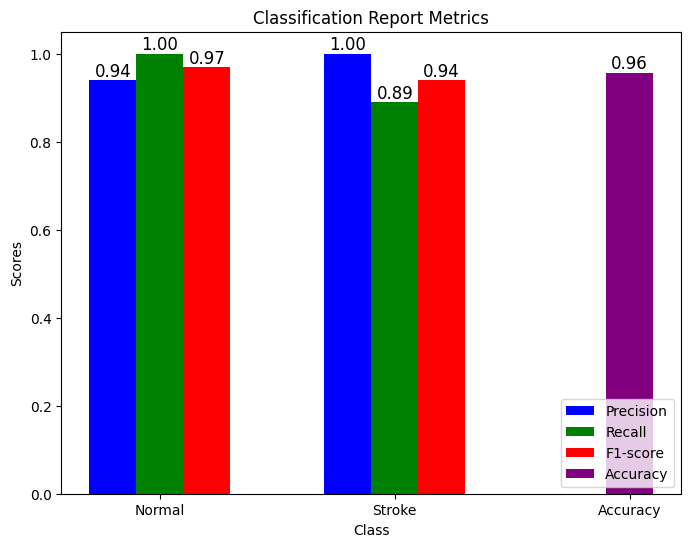

In [ ]:
#Plotting the bar graph for the classfication report.
import matplotlib.pyplot as plt
import numpy as np

report = {
    'Normal': {'precision': 0.94, 'recall': 1.00, 'f1-score': 0.97, 'support': 1551},
    'Stroke': {'precision': 1.00, 'recall': 0.89, 'f1-score': 0.94, 'support': 950}
}

accuracy = 0.9569

categories = ['Normal', 'Stroke']
precision = [report['Normal']['precision'], report['Stroke']['precision']]
recall = [report['Normal']['recall'], report['Stroke']['recall']]
f1_score = [report['Normal']['f1-score'], report['Stroke']['f1-score']]

x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2

bars1 = ax.bar(x - bar_width, precision, bar_width, label='Precision', color='blue')
bars2 = ax.bar(x, recall, bar_width, label='Recall', color='green')
bars3 = ax.bar(x + bar_width, f1_score, bar_width, label='F1-score', color='red')

acc_bar = ax.bar(len(categories), accuracy, bar_width, label='Accuracy', color='purple')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(acc_bar)

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(list(x) + [len(categories)])
ax.set_xticklabels(categories + ['Accuracy'])
ax.legend()
plt.show()

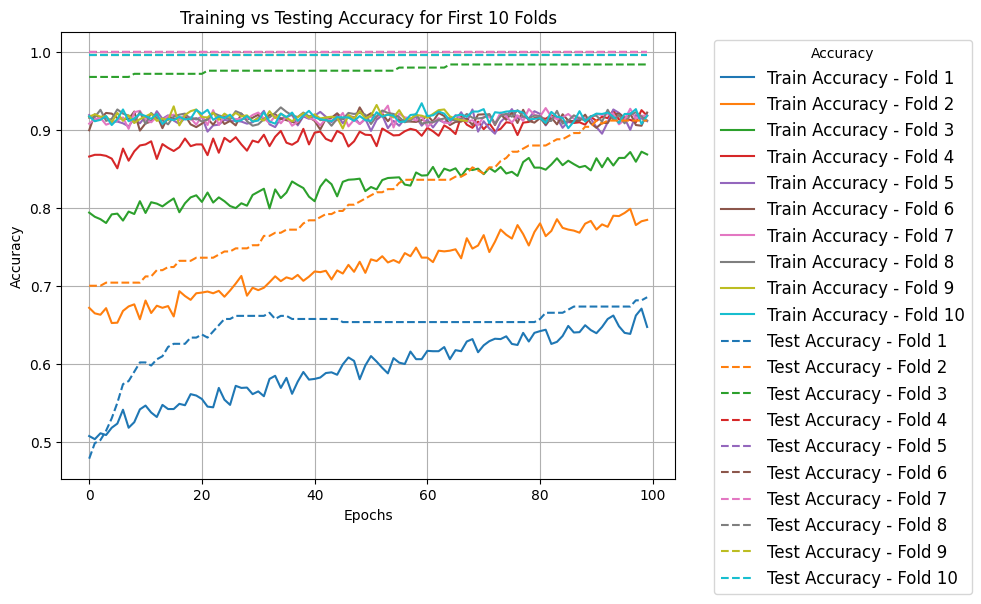

In [ ]:
import matplotlib.pyplot as plt

# Plotting Training vs Testing Accuracy for the first 10 folds
plt.figure(figsize=(10, 6))

for i, train_acc in enumerate(train_accuracies[:11]):
    plt.plot(train_acc, label=f'Train Accuracy - Fold {i+1}')

for i, test_acc in enumerate(test_accuracies[:11]):
    plt.plot(test_acc, label=f'Test Accuracy - Fold {i+1}', linestyle='dashed')

plt.title('Training vs Testing Accuracy for First 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Accuracy", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

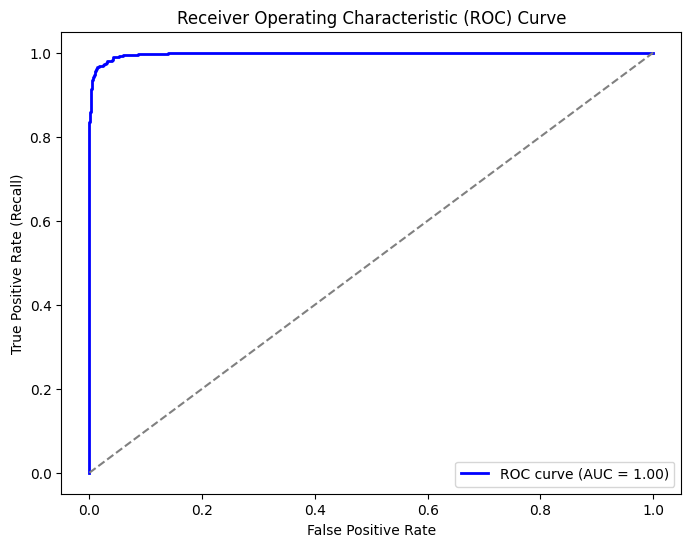

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_proba)

roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import tensorflow as tf

MODEL_PATH = '/content/drive/MyDrive/save_models/my_gru_model.keras'
# Load the saved model
loaded_model = tf.keras.models.load_model(MODEL_PATH)
print(f"Model loaded from {MODEL_PATH}")

Model loaded from /content/drive/MyDrive/save_models/my_gru_model.keras


In [ ]:
!pip install gtts

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pickle  # Use pickle for loading the PCA model
from tensorflow.keras.applications import VGG19
from gtts import gTTS
import os

# Load pre-trained models and PCA
MODEL_PATH = '/content/drive/MyDrive/save_models/my_gru_model.keras'
loaded_model = tf.keras.models.load_model(MODEL_PATH)

# Load PCA model using pickle
with open('/content/drive/MyDrive/save_models/pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

# Load the VGG19 model without the top layer for feature extraction
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(model, X):
    """Extract features using VGG19 model."""
    return model.predict(X)

def preprocess_and_predict(image_path, model, pca):
    """Preprocess and predict the class of an unknown image."""
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to (224, 224)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img.astype('float32') / 255.0  # Normalize the image

    # Extract features using VGG19
    img_features = extract_features(vgg_model, img)
    img_features = img_features.flatten().reshape(1, -1)  # Flatten the features

    # Apply PCA transformation
    img_pca = pca.transform(img_features)
    img_pca_reshaped = img_pca.reshape(img_pca.shape[0], 1, img_pca.shape[1])  # Reshape for GRU

    # Make prediction using the trained GRU model
    prediction = model.predict(img_pca_reshaped)

    # Convert the prediction to class label (0: Normal, 1: Stroke)
    predicted_class = "Stroke" if prediction[0] > 0.5 else "Normal"

    return predicted_class

def generate_audio(label):
    """Generate audio feedback."""
    if label == "Stroke":
        text = "The person is showing signs of stroke. Please consult a doctor immediately."
    else:
        text = "The person is not showing signs of stroke."
    tts = gTTS(text=text, lang='en')
    audio_path = "/content/drive/MyDrive/save_models/classification_result.mp3"
    tts.save(audio_path)
    return audio_path

def get_stroke_symptoms():
    """Return the symptoms of a stroke."""
    return (
        "Symptoms of Stroke:\n"
        "- Sudden numbness or weakness in the face, arm, or leg (especially on one side of the body).\n"
        "- Sudden confusion, trouble speaking, or difficulty understanding speech.\n"
        "- Sudden trouble seeing in one or both eyes.\n"
        "- Sudden trouble walking, dizziness, loss of balance or coordination.\n"
        "- Severe headache with no known cause."
    )

def get_precautions(label):
    """Generate stroke precautions."""
    if label == "Stroke":
        return (
            "Precautions:\n"
            "- Consult a doctor immediately.\n"
            "- Monitor symptoms like difficulty speaking, weakness, or numbness.\n"
            "- Avoid strenuous activity.\n"
            "- Keep the patient calm and hydrated."
        )
    return "No precautions needed. The person is normal."

def classify_image(input_image):
    """Classify the uploaded image."""
    image_path = "/content/drive/MyDrive/save_models/uploaded_image.jpg"
    cv2.imwrite(image_path, input_image)  # Save the uploaded image

    # Make prediction
    label = preprocess_and_predict(image_path, loaded_model, pca)

    # Generate audio and precautions
    audio_path = generate_audio(label)
    symptoms = get_stroke_symptoms() if label == "Stroke" else "No symptoms"
    precautions = get_precautions(label)

    return label, image_path, symptoms, precautions, audio_path

def interface(image):
    """Interface function for Gradio."""
    label, image_path, symptoms, precautions, audio_path = classify_image(image)

    # Display the uploaded image
    display_image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for display in Gradio

    return label, display_image, symptoms, precautions, audio_path

# Create the Gradio interface
with gr.Blocks() as gui:
    gr.Markdown('<h2 style="color: white; text-align: center;">"Early detection saves lives. Stay aware, stay healthy."</h2>')

    gr.Markdown("# Stroke Detection System")
    gr.Markdown("Upload a CT brain image to classify as **Stroke** or **Normal**.")

    background_image = gr.Image(value="/content/BRAIN.jpg", label="", interactive=False)

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(label="Upload Image", type="numpy")
            classify_button = gr.Button("Classify")
        with gr.Column():
            label_output = gr.Label(label="Result")
            image_output = gr.Image(label="Selected Image")
            symptoms_output = gr.Textbox(label="Symptoms", interactive=False)
            precautions_output = gr.Textbox(label="Precautions", interactive=False)

    audio_output = gr.Audio(label="Audio Feedback", type="filepath", interactive=False)

    classify_button.click(
        interface,
        inputs=image_input,
        outputs=[label_output, image_output, symptoms_output, precautions_output, audio_output]
    )

# Launch the Gradio interface
gui.launch()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d71b1f53a20578827e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
